In [ ]:
# --- Setup inicial ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import pearsonr
from sklearn.preprocessing import LabelEncoder

# Visual configs
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Load dataset
df = pd.read_csv("data/amazon_uk_products.csv")
df.head()


,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers


In [7]:
# Crosstab entre categoria e best-seller
ct = pd.crosstab(df['category'], df['isBestSeller'])
ct_prop = ct.div(ct.sum(axis=1), axis=0).sort_values(by=True, ascending=False)

# Visualizar as 10 principais categorias com maior % de best-sellers
ct_prop.head(10)


isBestSeller,False,True
category,,
Grocery,0.941865,0.058135
Smart Home Security & Lighting,0.942308,0.057692
Health & Personal Care,0.942314,0.057686
Mobile Phone Accessories,0.957529,0.042471
Power & Hand Tools,0.964661,0.035339
"Billiard, Snooker & Pool",0.967871,0.032129
Pet Supplies,0.969800,0.030200
Home Brewing & Wine Making,0.971545,0.028455
Mirrors,0.972000,0.028000


In [8]:
from scipy.stats import chi2_contingency
import numpy as np

chi2, p, dof, ex = chi2_contingency(ct)
cramers_v = np.sqrt(chi2 / (len(df) * (min(ct.shape)-1)))

print(f"Chi² p-value: {p:.5f}")
print(f"Cramér’s V: {cramers_v:.3f}")


Chi² p-value: 0.00000
Cramér’s V: 0.122


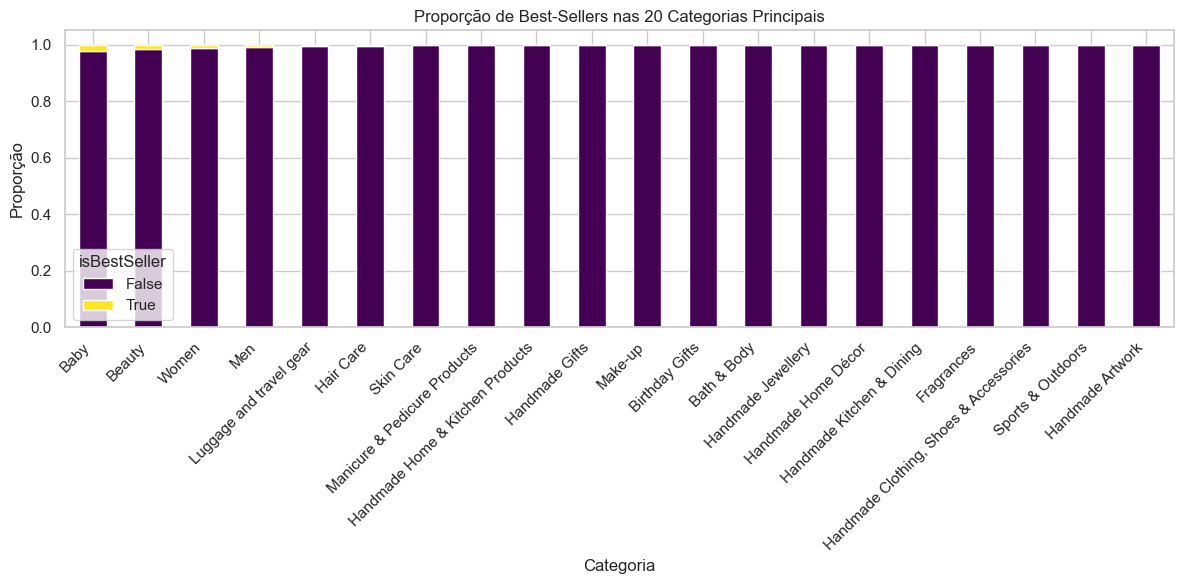

In [10]:
# Selecionar as 20 categorias mais comuns
top_categories = df['category'].value_counts().head(20).index

# Filtrar o crosstab para essas categorias
ct_top = pd.crosstab(df[df['category'].isin(top_categories)]['category'],
                     df['isBestSeller'])

ct_top_prop = ct_top.div(ct_top.sum(axis=1), axis=0).sort_values(by=True, ascending=False)

# Plotar novamente
ct_top_prop.plot(kind='bar', stacked=True, figsize=(12,6), colormap='viridis')
plt.title("Proporção de Best-Sellers nas 20 Categorias Principais")
plt.ylabel("Proporção")
plt.xlabel("Categoria")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Tamanho original: 2443651, sem outliers: 2115963


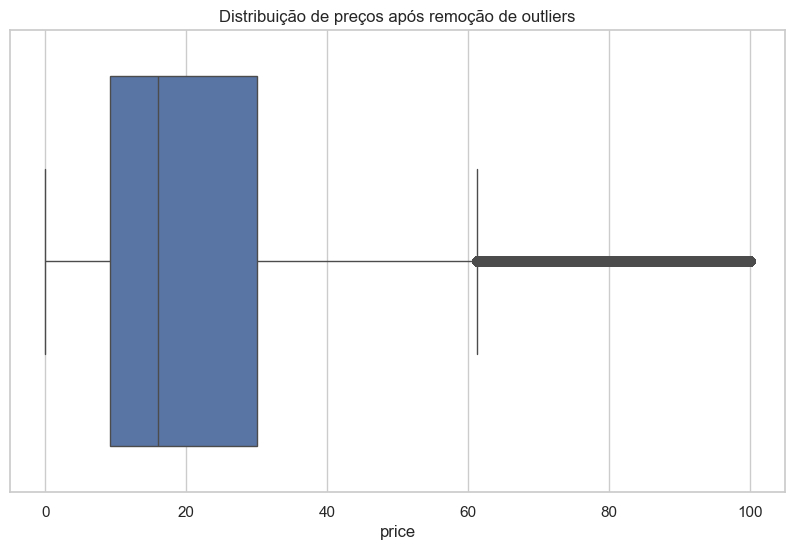

In [12]:
# --- Remover outliers de preço usando o método IQR ---

# 1. Calcular os quartis (Q1 = 25%, Q3 = 75%)
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)

# 2. Calcular o intervalo interquartílico (IQR = Q3 - Q1)
IQR = Q3 - Q1

# 3. Definir limites inferiores e superiores
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 4. Filtrar os dados dentro dos limites
df_no_outliers = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

# 5. Mostrar a diferença no tamanho do dataset
print(f"Tamanho original: {len(df)}, sem outliers: {len(df_no_outliers)}")

# 6. Visualizar a distribuição após a limpeza
sns.boxplot(x=df_no_outliers['price'])
plt.title("Distribuição de preços após remoção de outliers")
plt.show()


/var/folders/k3/c13ddj7d46n3kbwd2zx925mm0000gn/T/ipykernel_6665/2903944530.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


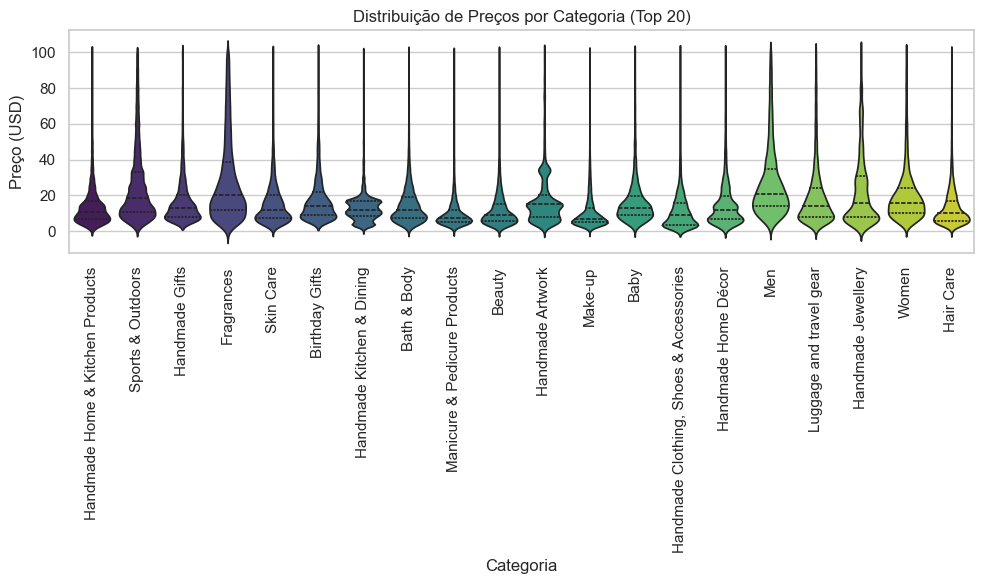

In [13]:
# --- Visualizar a distribuição de preços por categoria ---

# 1. Selecionar as 20 categorias mais frequentes
top_cats = df_no_outliers['category'].value_counts().head(20).index

# 2. Criar o violin plot
sns.violinplot(
    data=df_no_outliers[df_no_outliers['category'].isin(top_cats)],
    x='category',
    y='price',
    inner='quartile',   # mostra as medianas dentro do violino
    palette='viridis'
)

plt.xticks(rotation=90)
plt.title("Distribuição de Preços por Categoria (Top 20)")
plt.xlabel("Categoria")
plt.ylabel("Preço (USD)")
plt.tight_layout()
plt.show()


/var/folders/k3/c13ddj7d46n3kbwd2zx925mm0000gn/T/ipykernel_6665/1823952158.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top10_price.values, y=top10_price.index, palette='coolwarm')


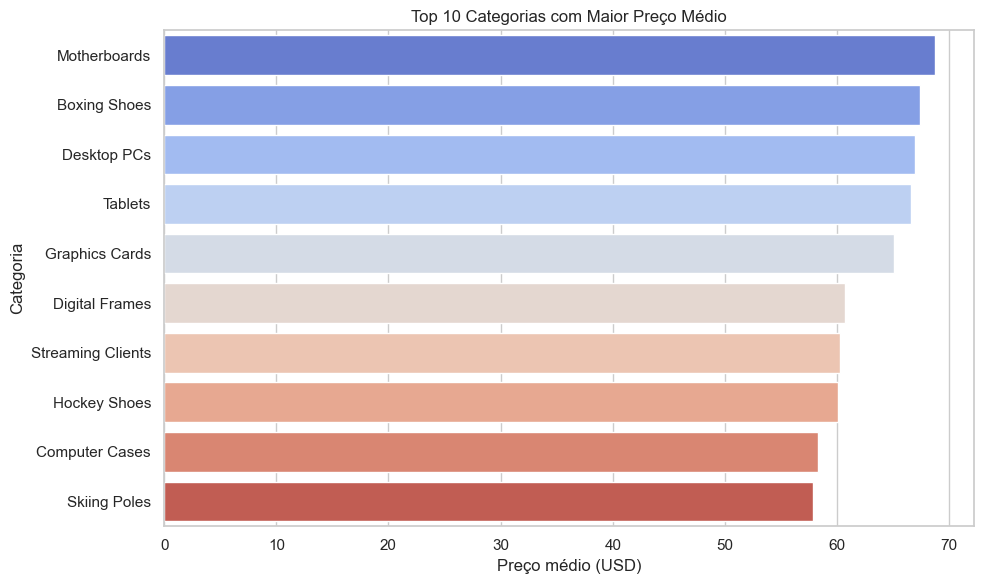

category
Motherboards         68.772432
Boxing Shoes         67.417803
Desktop PCs          66.915562
Tablets              66.552971
Graphics Cards       65.103509
Digital Frames       60.745129
Streaming Clients    60.241803
Hockey Shoes         60.094796
Computer Cases       58.339884
Skiing Poles         57.867770
Name: price, dtype: float64

In [14]:
# --- Comparar preço médio por categoria (Top 10) ---

# 1. Calcular preço médio por categoria
avg_price = df_no_outliers.groupby('category')['price'].mean().sort_values(ascending=False)

# 2. Selecionar as 10 categorias mais caras
top10_price = avg_price.head(10)

# 3. Plotar
sns.barplot(x=top10_price.values, y=top10_price.index, palette='coolwarm')
plt.title("Top 10 Categorias com Maior Preço Médio")
plt.xlabel("Preço médio (USD)")
plt.ylabel("Categoria")
plt.tight_layout()
plt.show()

# 4. Exibir as categorias mais caras
top10_price


/var/folders/k3/c13ddj7d46n3kbwd2zx925mm0000gn/T/ipykernel_6665/340716899.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


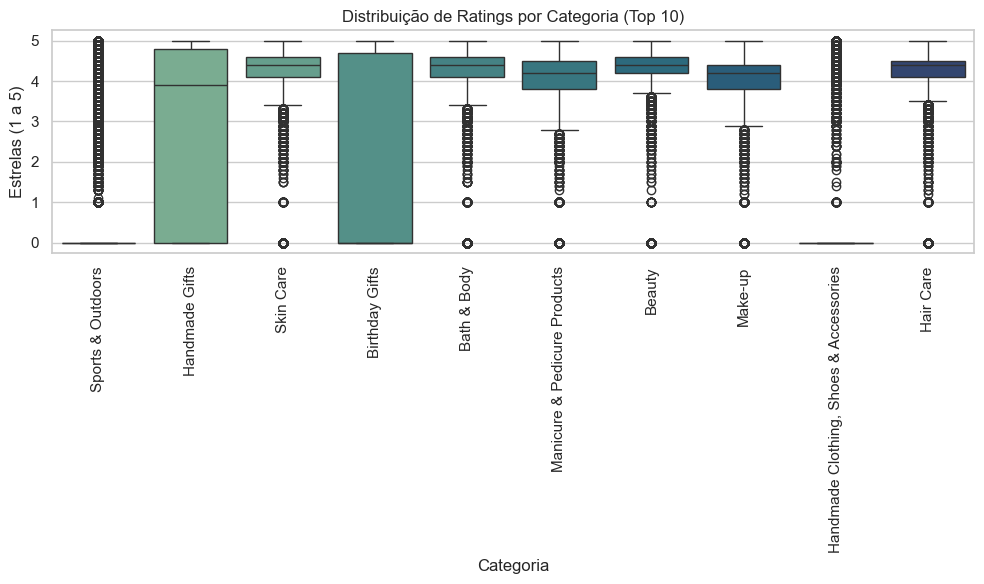

In [15]:
# --- Visualizar a distribuição de ratings (estrelas) por categoria ---

# 1. Selecionar as 10 categorias mais comuns
top_cats_rating = df_no_outliers['category'].value_counts().head(10).index

# 2. Plotar boxplot
sns.boxplot(
    data=df_no_outliers[df_no_outliers['category'].isin(top_cats_rating)],
    x='category',
    y='stars',
    palette='crest'
)

plt.xticks(rotation=90)
plt.title("Distribuição de Ratings por Categoria (Top 10)")
plt.xlabel("Categoria")
plt.ylabel("Estrelas (1 a 5)")
plt.tight_layout()
plt.show()


Most categories seem to have high ratings, around 4 to 5 stars, which means customers are generally satisfied.
A few categories show lower medians — maybe because they have more diverse products or quality differences.
This tells me that rating consistency can vary a lot between product types.

In [16]:
# --- Calcular a correlação entre preço e rating ---

from scipy.stats import pearsonr

# 1. Remover linhas com valores nulos em 'price' ou 'stars'
filtered = df_no_outliers.dropna(subset=['price', 'stars'])

# 2. Calcular o coeficiente de correlação de Pearson
corr, p_value = pearsonr(filtered['price'], filtered['stars'])

# 3. Mostrar o resultado
print(f"Correlação (Pearson): {corr:.3f}")
print(f"p-value: {p_value:.5f}")


Correlação (Pearson): -0.078
p-value: 0.00000


The correlation value is very close to 0, meaning that price and rating don’t really move together.
Expensive products are not necessarily rated higher, and cheap ones are not automatically worse.
In short, customers seem to judge quality more by usefulness than by cost.

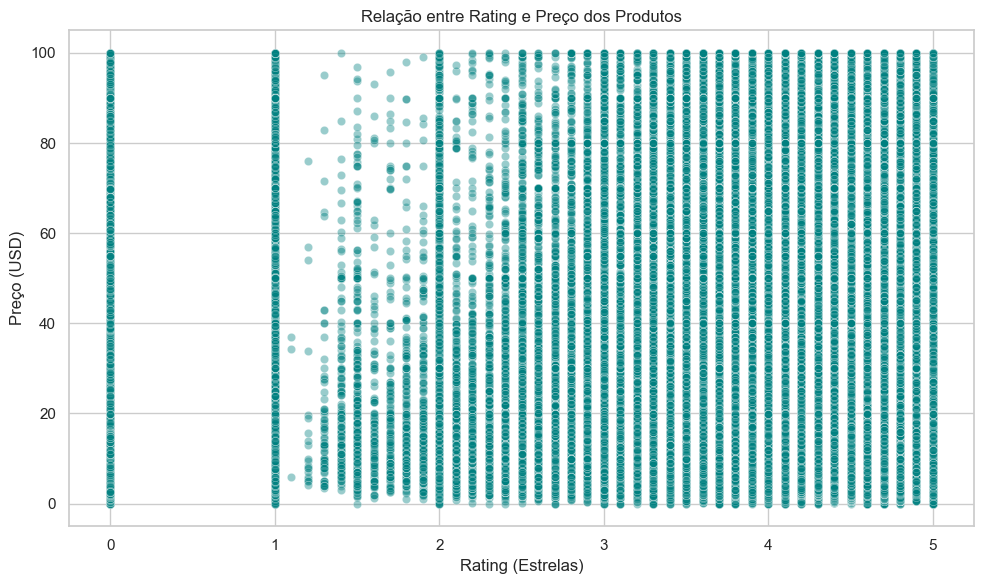

In [17]:
# --- Visualizar a relação entre preço e rating com um scatter plot ---

sns.scatterplot(
    data=filtered,
    x='stars',
    y='price',
    alpha=0.4,             # transparência para melhor visualização
    color='teal'
)

plt.title("Relação entre Rating e Preço dos Produtos")
plt.xlabel("Rating (Estrelas)")
plt.ylabel("Preço (USD)")
plt.tight_layout()
plt.show()


Cada ponto representa um produto.
Se houvesse correlação positiva, veríamos uma tendência crescente: quanto maior o rating, maior o preço.
Mas se os pontos estiverem espalhados sem padrão, não há relação clara.

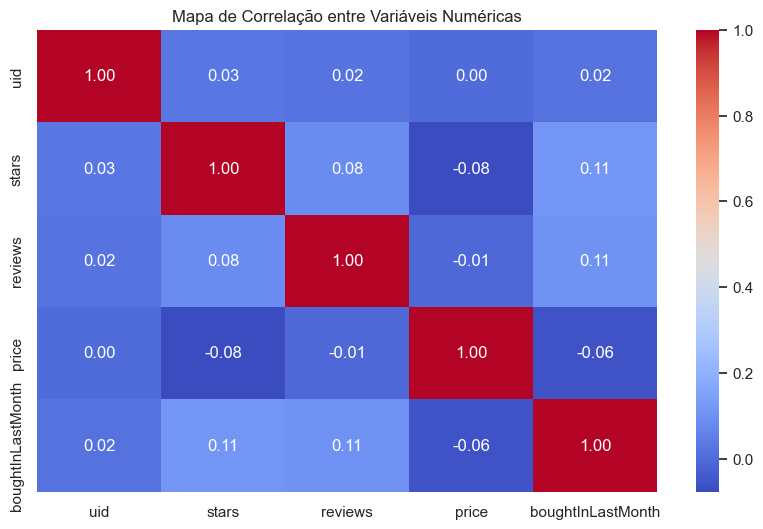

In [18]:
# --- Visualizar as correlações entre variáveis numéricas ---

# 1. Selecionar apenas colunas numéricas
numeric_cols = df_no_outliers.select_dtypes(include='number')

# 2. Matriz de correlação
corr_matrix = numeric_cols.corr()

# 3. Heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Mapa de Correlação entre Variáveis Numéricas")
plt.show()


O heatmap é ótimo para ver rapidamente todas as correlações entre variáveis.
Valores próximos de 1 ou -1 indicam relações fortes; próximos de 0 indicam independência.

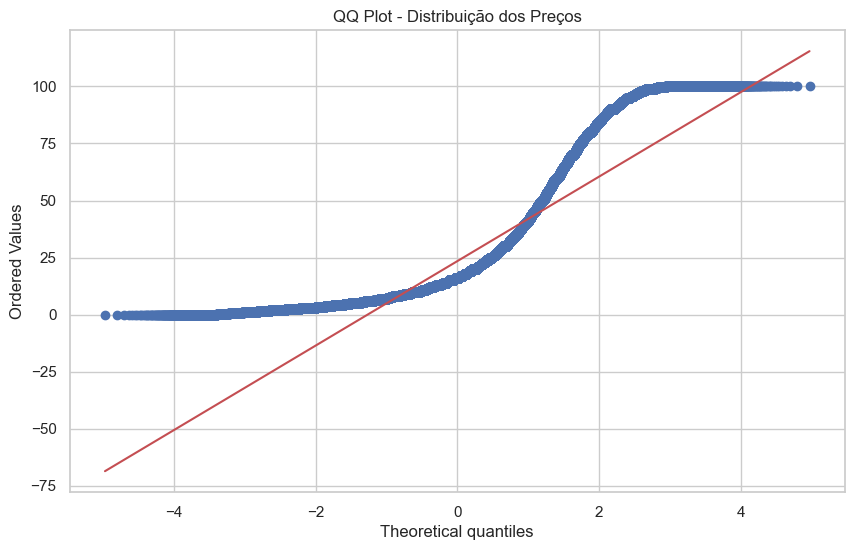

In [19]:
# --- Verificar se os preços têm distribuição normal ---

import scipy.stats as stats
import matplotlib.pyplot as plt

# 1. Criar o QQ Plot
stats.probplot(filtered['price'], dist="norm", plot=plt)
plt.title("QQ Plot - Distribuição dos Preços")
plt.show()


O QQ Plot compara a distribuição dos preços com uma normal teórica.
Se os pontos estiverem próximos da linha diagonal, os dados seguem uma distribuição normal;
se houver curvatura forte, os preços são assimétricos (muito comum em dados econômicos).

The scatter plot looks very random, and the heatmap confirms it — price and rating are almost independent.
That makes sense: a good product doesn’t always have to be expensive.
For me, this means that customer satisfaction depends more on performance and expectations than on how much they paid.